In [1]:
import jax.numpy as jnp
import jax
import src.models
from experiments.plotting import plot_score_variable_y, plot_score_error_variable_y

import orbax.checkpoint
from src.training import utils
import flax.linen as nn



In [2]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()


sde = {"x0": (1.,), "N": 100, "dim": 1, "T": 1., "y": (5.,)}
network = {
    "output_dim": sde["dim"],
    "time_embedding_dim": 16,
    "init_embedding_dim": 16,
    "activation": nn.leaky_relu,
    "encoder_layer_dims": [16],
    "decoder_layer_dims": [128, 128],
}

training = {
    "batch_size": 1000,
    "epochs_per_load": 1,
    "lr": 0.01,
    "num_reloads": 1000,
    "load_size": 1000,
}


num_samples = training["batch_size"] * sde["N"]
x_shape = jnp.empty(shape=(num_samples, sde["dim"]))
t_shape = jnp.empty(shape=(num_samples, 1))
model = src.models.ScoreMLPDistributedEndpt(**network)
empty_train_state = utils.create_train_state(model, jax.random.PRNGKey(0), training["lr"], x_shape, x_shape, t_shape)
target = {"state":empty_train_state, "sde":sde, "network":network, "training":training}

restored = orbax_checkpointer.restore('/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/ou/varied_y_-1.0_to_1.0', item=target)
train_state = restored["state"]
trained_score = utils.trained_score_variable_y(train_state)


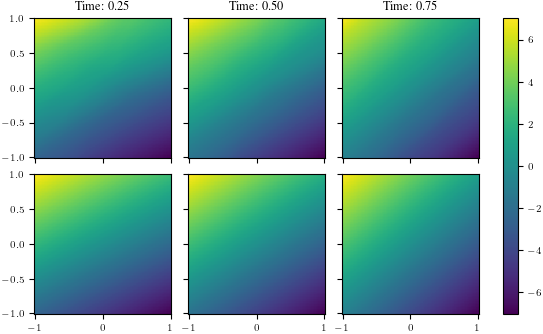

(<Figure size 550x339.919 with 7 Axes>,
 array([[<Axes: title={'center': 'Time: 0.25'}>,
         <Axes: title={'center': 'Time: 0.50'}>,
         <Axes: title={'center': 'Time: 0.75'}>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

In [5]:
from src.data_generate_sde import sde_ornstein_uhlenbeck

from tueplots import bundles
import matplotlib.pyplot as plt

bundle = bundles.neurips2023()
plt.rcParams.update(bundle)

true_score = sde_ornstein_uhlenbeck.score
plot_score_variable_y(true_score, trained_score, -1, 1, -1, 1)


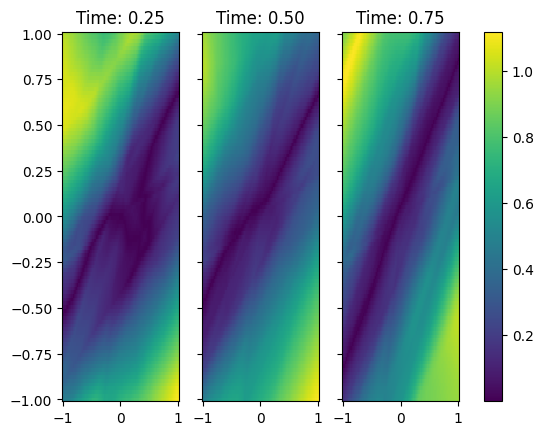

In [4]:
plot_score_error_variable_y(true_score, trained_score, -1, 1, -1, 1)